<a href="https://colab.research.google.com/github/ansar2019/image-captionig/blob/main/Fuyu_8B_Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers bitsandbytes accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 29.0 MB/s eta 0:00:00


In [2]:
import time
import cv2
import numpy as np
import torch
from google.colab.patches import cv2_imshow
from urllib.request import Request, urlopen
from transformers import AutoTokenizer, FuyuProcessor, FuyuImageProcessor, FuyuForCausalLM, BitsAndBytesConfig
import pdb

In [3]:
def url_to_image(url):
  """get image from web url"""
  #definition of User-Agent in header due to website blocking, also see here: https://stackoverflow.com/questions/16627227/problem-http-error-403-in-python-3-web-scraping
  req = Request(url=url, headers={'User-Agent': 'Mozilla/6.0'})
  resp = urlopen(req).read()
  image = np.asarray(bytearray(resp), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  return image

def show(image):
  """show an image in line"""
  cv2_imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

def pprint(text, line_char=88):
  """pretty print text by limit line characters"""
  last_char = "" # handle last word in each line
  for i in range(0, len(text), line_char):
    line = text[i:i+line_char]
    line = last_char+line
    last_char = ""
    line = line.split(" ")
    last_char = line[-1]
    if i <= len(text)-line_char:
      # handle last word in last line
      line = line[:-1]
    print(" ".join(line))

def run_example(prompt, img_url):
  """run example with prompt and image url"""
  # get and show image
  image = url_to_image(img_url)
  show(image)
  # run the model
  output = fuyu.prompt(prompt, image, out_tokens=100)
  # pretty print example info
  pprint(f"\nGiven \x1b[1;31mimage\x1b[0m \x1B[3m{img_url}\x1B[0m \x1b[1;31mand\x1b[0m the following \x1b[1;31mprompt\x1b[0m:\n\n\x1B[3m{prompt}\x1B[0m", 80)
  pprint(f"The \x1b[1;31mmodels output\x1b[0m:\n\n\x1B[3m{output}\x1B[0m\n", 88)



In [4]:
# check runtime type
if torch.cuda.is_available():
  model_id="ybelkada/fuyu-8b-sharded"
  print(f"\nUsing the sharded model '{model_id}' with to GPU usage.\n")
  print("This model is faster due to 4bit quantization and GPU computation. 🚀\n")
else:
  model_id="adept/fuyu-8b"
  print(f"\nUsing the original model '{model_id}' without GPU usage.\n")
  print("This model, as of today, can't be 4bit quantized. Also the weights can't be fully loaded into memory in colab free tier.")
  print("Running it on CPU and without the above optimizations makes it extremely slow in computation, however you can still do it and run this 8 billion parameter model!\n")
  print("⚠️ For the sake of time, switch the runtime type to 'T4 GPU' or any other GPU type, otherwise it will take literally hours!\n")



Using the sharded model 'ybelkada/fuyu-8b-sharded' with to GPU usage.

This model is faster due to 4bit quantization and GPU computation. 🚀



In [5]:
class Fuyu():
    """Pretrained fuyu model of Adept via huggingface"""

    def __init__(self, model_id="ybelkada/fuyu-8b-sharded"):
        # check if GPU can be used
        if torch.cuda.is_available():
            print("You are running the model on GPU.")
            self.device = torch.device("cuda")
            self.dtype = torch.float16
            quantization_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_compute_dtype=self.dtype
            )
            self.model = FuyuForCausalLM.from_pretrained(model_id, quantization_config=quantization_config)
        else:
            print("You are running the model on CPU, the runtime might be very slow. 🐌")
            self.device = torch.device("cpu")
            self.dtype = torch.bfloat16
            # 4bit quantization is currently not working with the latest version of transformers (as of today: 4.35.0.dev0), it is working with transformers 4.30, however fuyu is not integrated there.
            self.model = FuyuForCausalLM.from_pretrained(model_id, device_map=self.device, torch_dtype=self.dtype)

        # initialize tokenizer and fuyu processor, pretrained and via huggingface
        self.tokenizer = AutoTokenizer.from_pretrained(model_id)
        self.processor = FuyuProcessor(image_processor=FuyuImageProcessor(), tokenizer=self.tokenizer)

    def prompt(self, text, image=None, out_tokens=50):
        """Prompt the model with a text and optional an image prompt."""

        if image is None:
            # if no image is provided, use a small black image
            # Warning: This is working but the model is not trained on this image fake. Test purpose only!
            image = np.zeros((30,30,3), dtype=np.uint8)

        # pre processing image and text
        inputs = self.processor(text=text, images=[image], return_tensors="pt").to(self.device)
        prompt_len = inputs["input_ids"].shape[-1]

        # process
        t0 = time.time()
        generation_output = self.model.generate(**inputs, max_new_tokens=out_tokens, pad_token_id=self.tokenizer.eos_token_id)
        print(f"\nGeneration time: {time.time()-t0:.0f}s")

        # post processing
        generation_text = self.tokenizer.decode(generation_output[0][prompt_len:], skip_special_tokens=True)
        return generation_text.lstrip()

In [6]:
fuyu = Fuyu(model_id)

You are running the model on GPU.


config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/60.5k [00:00<?, ?B/s]

model-00001-of-00011.safetensors:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

model-00002-of-00011.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

model-00003-of-00011.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

model-00004-of-00011.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00005-of-00011.safetensors:   0%|          | 0.00/1.91G [00:00<?, ?B/s]

model-00006-of-00011.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

model-00007-of-00011.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

model-00008-of-00011.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00009-of-00011.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

model-00010-of-00011.safetensors:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

model-00011-of-00011.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/11 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/848 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/6.13M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

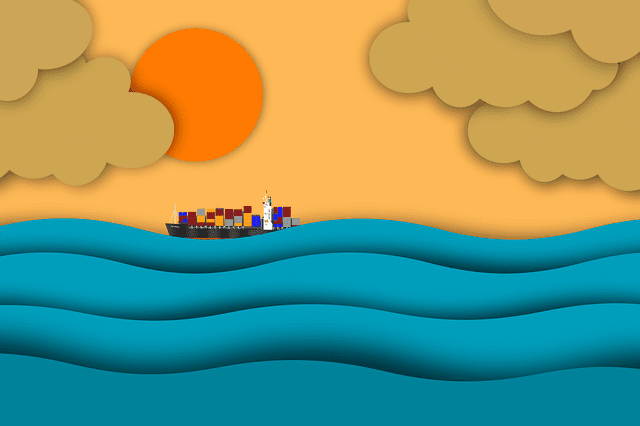


Generation time: 7s
The image features a large boat floating on the water, surrounded by clouds and waves.
There is also a smaller boat nearby. These objects together create a sense of an ocean
scene, capturing the essence of the ocean and its environment. The boats are floating on
calm waters, emphasizing a sense of tranquility and relaxation.


In [7]:
prompt= "Explain what objects are in this image."        #@param {type:"string"}
image_url = "https://learnopencv.com/wp-content/uploads/2021/04/image-15.png"        #@param {type:"string"}
out_tokens = 50           #@param {type:"slider", min:0, max:100, step:1}

# show image
image = url_to_image(image_url)
show(image)

# run model
output = fuyu.prompt(prompt, image, out_tokens=out_tokens)
pprint(output)

In [8]:
from google.colab import drive
drive.mount('/content/Drive')


Mounted at /content/Drive


In [11]:
import glob
from PIL import Image
filenames = glob.glob("/content/Drive/MyDrive/testdata/*.jpg")
filenames.sort()
for image in filenames:
  input_image = cv2.imread(image)
  gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
  input_image = Image.open(image)
  prompt= "Explain what objects are in this image." #@param {t
  out_tokens = 60
  output = fuyu.prompt(prompt, input_image, out_tokens=out_tokens)
  print(image,output)
  with open('Fuyu_8B.txt', 'a') as fp:
    fp.write(str([image])+str([output.encode('utf-8')]))
    fp.write('\n')


Generation time: 3s
/content/Drive/MyDrive/testdata/File 001.jpg The image features a wooden podium with an American flag behind it. Two men are standing behind the podium, one on the left and the other on the right. They are likely speaking or presenting at the event.


Generation time: 2s
/content/Drive/MyDrive/testdata/File 002.jpg The image features a group of four children sitting in chairs at a desk, working on projects together. They are all wearing pink shirts and are surrounded by books, indicating that they might be in a classroom setting.


Generation time: 5s
/content/Drive/MyDrive/testdata/File 003.jpg In the image, there are three women sitting at a table, enjoying a meal together. They are surrounded by various tableware, including cups, forks, knives, and spoons. There are also chairs surrounding the dining table.

The table is surrounded by several chairs, with one chair placed on the left side, another on the right side,

Generation time: 3s
/content/Drive/MyDrive/te